# Installing and Importing Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import os

Mounted at /content/drive


# Load Dataset

In [ ]:
dataset_path = "/content/drive/MyDrive/BTP/text_image_dataset"
csv_path = "labels.csv"

In [ ]:
import pandas as pd
data = pd.read_csv(csv_path)
print(data.head())

                      filename   font
0  font_0_sample_0_size_16.png  Arial
1  font_0_sample_1_size_16.png  Arial
2  font_0_sample_2_size_16.png  Arial
3  font_0_sample_3_size_16.png  Arial
4  font_0_sample_4_size_16.png  Arial


# Data Preprocessing

In [ ]:
fonts = ["Arial", "Times New Roman", "Courier New", "Verdana", "Georgia"]
font_to_label = {font: idx for idx, font in enumerate(fonts)}

images = []
labels = []

for index, row in data.iterrows():
    image_path = os.path.join(dataset_path, row['filename'])
    if os.path.exists(image_path):

        img = Image.open(image_path).convert("L")
        img = img.resize((32, 32))
        img = np.array(img) / 255.0

        images.append(img)
        labels.append(font_to_label[row['font']])

images = np.array(images).reshape(-1, 32, 32, 1)
labels = to_categorical(labels, num_classes=len(fonts))

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


# data visualization

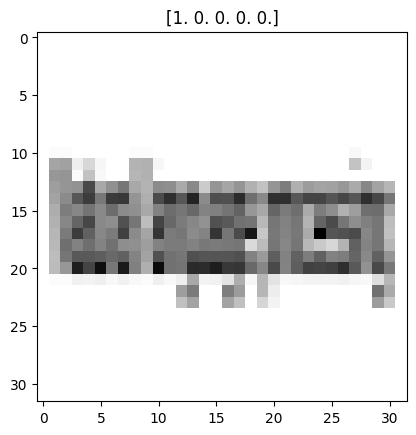

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[1], cmap='gray')
plt.title(labels[1])
plt.show()

# LeNet Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(42)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          # Training stops if the monitored metric (val_loss) doesn't improve for 10 consecutive epochs.
    restore_best_weights=True  # Restore weights from the epoch with the best value of the monitored metric
)

def create_lenet():
    model = models.Sequential([
        layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1), padding='valid',
                      kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),

        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, (5, 5), activation='relu', padding='valid',
                      kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),

        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(120, activation='relu',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),

        layers.Dense(84, activation='relu',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),

        layers.Dense(len(fonts), activation='softmax',
                     kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
    ])
    return model

model = create_lenet()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,281 (239.38 KB)

 Trainable params: 61,281 (239.38 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_split=0.2,  # Automatically split off 20% for validation
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.1744 - loss: 1.7087 - val_accuracy: 0.3125 - val_loss: 1.5740
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2522 - loss: 1.5999 - val_accuracy: 0.3542 - val_loss: 1.5553
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4499 - loss: 1.5559 - val_accuracy: 0.3958 - val_loss: 1.5185
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4158 - loss: 1.5240 - val_accuracy: 0.3958 - val_loss: 1.4804
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4504 - loss: 1.4871 - val_accuracy: 0.4583 - val_loss: 1.4281
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4987 - loss: 1.4446 - val_accuracy: 0.4375 - val_loss: 1.3681
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4721 - loss: 1.4057 - val_accuracy: 0.4375 - val_loss: 1.3168
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5202 - loss: 1.3439 - val_accuracy: 0.4375 - val_loss:

# Saving Model

In [ ]:
model.save("lenet_font_recognition.h5")

# Predicting new image

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("lenet_font_recognition.h5")

new_image_path = "/content/drive/MyDrive/BTP/text_image_dataset/font_4_sample_2_size_32.png"
new_image = Image.open(new_image_path).convert("L").resize((32, 32))
new_image = np.array(new_image) / 255.0
new_image = new_image.reshape(1, 32, 32, 1)

predictions = model.predict(new_image)
predicted_font = fonts[np.argmax(predictions)]
print(f"Predicted Font: {predicted_font}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted Font: Georgia


# Evaluation Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_test_classes = np.argmax(y_test, axis=1)

predictions = np.argmax(model.predict(x_test), axis=1)
print(confusion_matrix(y_test_classes, predictions))
print(classification_report(y_test_classes, predictions))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[[11  0  0  0  0]
 [ 0 15  1  0  0]
 [ 0  0  7  0  0]
 [ 0  0  1 16  0]
 [ 0  0  1  0  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.94      0.97        16
           2       0.70      1.00      0.82         7
           3       1.00      0.94      0.97        17
           4       1.00      0.89      0.94         9

    accuracy                           0.95        60
   macro avg       0.94      0.95      0.94        60
weighted avg       0.96      0.95      0.95        60

